# Simple Genetic Algorithm

In [1]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import random as rnd
import pandas as pd

## Data (Travelling Salesman Problem)

In [2]:
# Define the location of each city
X = [5, 10, 23, 34, 45, 60, 50, 45, 30, 20]
Y = [10, 30, 55, 50, 58, 53, 40, 25, 20, 10]
city_map = dict(enumerate(zip(X,Y))) # A dict mapping of city index to location
city_map

{0: (5, 10),
 1: (10, 30),
 2: (23, 55),
 3: (34, 50),
 4: (45, 58),
 5: (60, 53),
 6: (50, 40),
 7: (45, 25),
 8: (30, 20),
 9: (20, 10)}

In [3]:
cities = list(city_map.keys()) # all indices of cities
cities

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

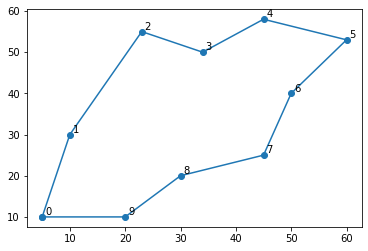

In [4]:
# Plot the cities
plt.scatter(X + [X[0]], Y + [Y[0]])
for i, (x, y) in enumerate(zip(X,Y)):
    plt.annotate(i, (x, y), (x+0.5, y+0.5))
plt.plot(X + [X[0]], Y + [Y[0]])
# This is also the ideal solution that we expect the model to learn

## Initialization of population

In [5]:
def initialize_pop(pop_size=10):
    population = []
    for i in range(pop_size):
        individual = cities.copy()
        rnd.shuffle(individual) # shuffle the cities
        population.append(individual)
    return population

In [6]:
sample_pop = initialize_pop(pop_size=5)
sample_pop

[[8, 5, 7, 2, 9, 4, 1, 0, 3, 6],
 [1, 0, 7, 5, 9, 3, 4, 6, 2, 8],
 [7, 6, 0, 5, 4, 8, 2, 3, 1, 9],
 [2, 9, 4, 5, 1, 7, 3, 8, 6, 0],
 [4, 1, 9, 6, 8, 5, 2, 0, 3, 7]]

## Fitness Function

In [7]:
def fitness(solution):
    '''Returns the total travel distance for a given solution'''
    total_distance = 0
    
    # Calculate the acyclic distance from first city to last city
    for i in range(len(solution)-1):
        p1 = city_map[solution[i]]
        p2 = city_map[solution[i+1]]
        total_distance += euclidean(p1, p2)
    
    # Complete the loop by adding the distance between last city and first city
    p1 = city_map[solution[-1]]
    p2 = city_map[solution[0]]
    total_distance += euclidean(p1, p2)
       
    return total_distance

In [8]:
# fitness of an individual from sample population
fitness(sample_pop[0])

374.78135132186304

## Selection

In [9]:
def selection(population):
    '''Selects an individual randomly based on its fitness value as weights'''
    # Calculate the fitness values of every individual in the population
    fitness_values = list(map(fitness, population))
    # Calculate the relative inverse fitness as our goal is to minimize the total distance
    inverse_fitness = [max(fitness_values) - x for x in fitness_values]
    # Assign weights to each individual based on the inverse fitness
    weights = [x / sum(inverse_fitness) for x in inverse_fitness]
    # Select a individual as a parent with weighted randomness
    selected_individual = rnd.choices(population, weights)[0]
    
    return selected_individual

In [10]:
selection(sample_pop)

[1, 0, 7, 5, 9, 3, 4, 6, 2, 8]

## Crossover

In [18]:
def crossover(parent1, parent2, prnt=False):
    '''Returns the child after crossover between the parents'''
    # Select cut points
    c1 = rnd.randint(0, len(parent1)-2)
    c2 = rnd.randint(c1+1, len(parent2)-1)
    
    # Create an Empty Child DNA
    child = ["X"] * len(parent1)
    
    # Set the values between the cut points from parent1 in the child DNA
    child[c1:c2+1] = parent1[c1:c2+1]
    if prnt: print('Child DNA from Parent 1', child)
    
    # Fill the remaining values from parent2
    for i in range(len(child)):
        for j in range(len(parent2)):
            # If the parent value is not already in the child then
            if parent2[j] not in child:
                # Replace with parent value only at places marked X
                child[i] = parent2[j] if child[i] == "X" else child[i]
                # break out of the inner loop and move over to the next position in the DNA
                break
    
    if prnt: print('Child DNA after adding Parent 2', child)
    
    return child

In [19]:
parent1 = [5, 1, 4, 2, 7, 6, 3, 8, 0, 9]
parent2 = [5, 2, 9, 0, 7, 8, 1, 4, 6, 3]

In [21]:
child = crossover(parent1, parent2, prnt=True)

Child DNA from Parent 1 ['X', 'X', 'X', 'X', 'X', 'X', 'X', 8, 0, 9]
Child DNA after adding Parent 2 [5, 2, 7, 1, 4, 6, 3, 8, 0, 9]


## Mutation

In [22]:
def mutation(individual):
    '''Mutates the DNA of a child/individual by swapping the values at two positions'''
    # Selecting the index values to swap
    pos_1 = rnd.randint(0, len(individual)-1)
    pos_2 = rnd.randint(0, len(individual)-1)
    # Init the mutant
    mutant = individual.copy()
    # Swap
    mutant[pos_1] = individual[pos_2]
    mutant[pos_2] = individual[pos_1]
    
    return mutant

In [23]:
mutated_child = mutation(child)
print('Before Mutation', child)
print('After Mutation', mutated_child)

Before Mutation [5, 2, 7, 1, 4, 6, 3, 8, 0, 9]
After Mutation [5, 2, 3, 1, 4, 6, 7, 8, 0, 9]


## Putting Everything Together

In [24]:
def optimize_GA(pop_size, max_generations, crossover_prob, mutate_prob):
    '''Returns the final solution by optimizing using genetic algorithm'''

    # Initialize the Population
    population = initialize_pop(pop_size)
    global_best = {}

    # Start Evolution
    for g in range(max_generations):

        # Calculate Fitness of the population
        population_fitness = list(map(fitness, population))

        # Get the individual with the best fitness value (min distance value)
        best_fitness = min(population_fitness)
        best_fit_index = population_fitness.index(best_fitness)
        best_fit_individual = population[best_fit_index]

        # Check with global best
        if g == 0:
            global_best['fitness'] = best_fitness
            global_best['dna'] = best_fit_individual
        else:
            if best_fitness <= global_best['fitness']:
                global_best['fitness'] = best_fitness
                global_best['dna'] = best_fit_individual
#             print('Best Solution at Generation', g)

        new_population = []
        for i in range(pop_size):
            # Select the parents
            parent1 = selection(population)
            parent2 = selection(population)

            # Crossover between the parents with a certain probability
            if rnd.random() <= crossover_prob:
                child = crossover(parent1, parent2)
            else: # or directly clone one of the parents
                child = rnd.choice([parent1, parent2])

            # Mutation
            if rnd.random() <= mutate_prob:
                child = mutation(child)

            # Add child to new population
            new_population.append(child)

        population = new_population
    return global_best

In [50]:
# Hyperparameters
pop_size = 10
max_generations = 100
crossover_prob = 0.95
mutate_prob = 0.7

In [51]:
%%time
# Start Optimization with Genetic Algorithm
solution = optimize_GA(pop_size, max_generations, crossover_prob, mutate_prob)
solution

Wall time: 3.01 s


{'fitness': 167.45557021074242, 'dna': [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]}

## Visualizing the results

In [52]:
# Get the x,y coordinates of the cities for plotting
solution_points = np.array([city_map[x] for x in solution['dna']] + [city_map[solution['dna'][0]]])
solution_points

array([[20, 10],
       [30, 20],
       [45, 25],
       [50, 40],
       [60, 53],
       [45, 58],
       [34, 50],
       [23, 55],
       [10, 30],
       [ 5, 10],
       [20, 10]])

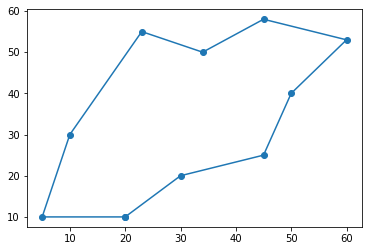

In [53]:
# Plot the Solution
X_sol = solution_points[:, 0]
Y_sol = solution_points[:, 1]

plt.scatter(X_sol, Y_sol)
plt.plot(X_sol, Y_sol)